# ML: Marketing Email Campaign 

## Goal

Optimizing marketing campaigns is one of the most common data science tasks. Among the many possible marketing tools, one of the most efficient is using emails.

Emails are great cause they are free and can be easily personalized. Email optimization involves personalizing the text and/or the subject, who should receive it, when should be sent, etc. Machine Learning excels at this.


## Challenge Description

The marketing team of an e-commerce site has launched an email campaign. This site has email addresses from all the users who created an account in the past.

They have chosen a random sample of users and emailed them. The email let the user know about a new feature implemented on the site. From the marketing team perspective, a success is if the user clicks on the link inside of the email. This link takes the user to the company site.

You are in charge of figuring out how the email campaign performed and were asked the following questions:

* What percentage of users opened the email and what percentage clicked on the link within the email?
* The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?
* By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email). How would you test that?
* Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

In this notebook, we will further investigate logistic regression models and answer (follow the link [Regressions and Coefficients](https://productds.com/wp-content/uploads/Logistic_Regression.html)) the fourth question in the last part.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data

### email_table

Info about each email that was sent.

* **email_id**: the Id of the email that was sent. It is unique by email
* **email_text**: there are two versions of the email: one has "long text" (i.e. has 4 paragraphs) and one has "short text" (just 2 paragraphs)
* **email_version**: some emails were "personalized" (i.e. they had the name of the user receiving the email in the incipit, such as "Hi John,"), while some emails were
"generic" (the incipit was just "Hi,").
* **hour**: the user local time when the email was sent.
* **weekday**: the day when the email was sent.
* **user_country**: the country where the user receiving the email was based. It comes from the user ip address when she created the account.
* **user_past_purchases**: how many items in the past were bought by the user receiving the email


In [3]:
data = pd.read_csv("email_table.csv")
print (data.shape)
data.head()

(100000, 7)


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


### email_opened_table

The id of the emails that were opened at least once.

* **email_id**: the id of the emails that were opened, i.e. the user clicked on the email and, supposedly, read it.


In [4]:
email_open = pd.read_csv("email_opened_table.csv")
print (email_open.shape)
email_open.head()

(10345, 1)


,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


### link_clicked_table
The id of the emails whose link inside was clicked at least once. This user was then brought to the site.

* **email_id**: if the user clicked on the link within the email, then the id of the email shows up on this table.

In [5]:
email_click = pd.read_csv("link_clicked_table.csv")
print (email_click.shape)
email_click.head()

(2119, 1)


,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


## Q1: What percentage of users opened the email and what percentage clicked on the link within the email?

In [6]:
email_open_set = set(email_open["email_id"])
data["open"] = data["email_id"].apply(lambda x: 1 if x in email_open_set else 0)
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open
0,85120,short_email,personalized,2,Sunday,US,5,0
1,966622,long_email,personalized,12,Sunday,UK,2,1
2,777221,long_email,personalized,11,Wednesday,US,2,0
3,493711,short_email,generic,6,Monday,UK,1,0
4,106887,long_email,generic,14,Monday,US,6,0


In [7]:
email_click_set = set(email_click["email_id"])
data["click"] = data["email_id"].apply(lambda x: 1 if x in email_click_set else 0)
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open,click
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [8]:
print ("open rate:" + str(float(len(data[data.open==1]))*100/len(data))+"%, clic rate:"+str(float(len(data[(data.open == 1) & (data.click == 1)]))*100/len(data[data.open==1]))+"%")

open rate:10.345%, clic rate:20.0%


## Q2: The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?

This is a supervised binary classification problem, where target variable is `click`. A logistic regression can be seen as a linear method with a particular link function (logit) to constrain the output between 0 and 1.

We can optimize the AUC, recall, precision etc:

* [AUC under ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
* [More generic metrics to optimize](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [9]:
data_categorical = data.select_dtypes(['object']).astype("category") 
print(data_categorical.apply(lambda x: x.cat.categories[0]))

email_text       long_email
email_version       generic
weekday              Friday
user_country             ES
dtype: object


In [10]:
data = pd.get_dummies(data, drop_first=True)

In [11]:
X, y = data.drop(['open', 'click', 'email_id'], axis=1), data["click"]

In [12]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import plot_roc_curve

def evaluation(y_test, pred):
    '''metric evaluation, F1, precision, recall'''
    conf_matrix = confusion_matrix(y_test, pred, labels=[1, 0])
    TP, FP, FN, TN = conf_matrix[0][0], conf_matrix[1][0], conf_matrix[0][1], conf_matrix[1][1]
    recall = TP*1.0/sum(y_test)
    precision = TP*1.0/sum(pred) if sum(pred) > 0 else 0
    F1_score = 2*precision*recall/(precision+recall) if precision+recall > 0 else 0
    print ('P = %.3f' % precision, 'R = %.3f' % recall)
    print ('F1 = %.3f' % F1_score)
    print (conf_matrix)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3);
print (X_train.shape, len(y_train), X_test.shape, len(y_test))

(70000, 13) 70000 (30000, 13) 30000


In [14]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
print ('accuracy = %.3f' % logreg.score(X_test, y_test))
evaluation(y_test, logreg.predict(X_test))
print ("AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))
# print (sum(pred), sum(y_test))

accuracy = 0.980
P = 0.000 R = 0.000
F1 = 0.000
[[    0   613]
 [    0 29387]]
AUC: 0.7274707424369101


/Users/hsianghsuanhung/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
rf = RandomForestClassifier(max_depth=10)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print ('accuracy = %.3f' % rf.score(X_test, y_test))
evaluation(y_test, rf.predict(X_test))
print ("AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
# print (sum(pred), sum(y_test))

accuracy = 0.980
P = 0.000 R = 0.000
F1 = 0.000
[[    0   613]
 [    0 29387]]
AUC: 0.7140787192081638


It is hard to capture positive behavior. In the following we downsample the negative events + grid search on models.

### Downsample negative events

In [16]:
X_train2 = X_train.copy()
X_train2["click"] = y_train

pos_data = X_train2[X_train2.click == 1]
neg_data = X_train2[X_train2.click == 0]

neg_data = neg_data.sample(frac = 0.04)

downsample_data = pd.concat([pos_data, neg_data], axis=0)

X_train2, y_train2 = downsample_data.drop(['click'], axis=1), downsample_data["click"]

print (X_train2.shape, len(y_train2))

(4246, 13) 4246


### Grid Search 

In [17]:
def gridsearch_lr(X_train, y_train, reg=[0.2, 0.4, 0.6, 0.8, 1, 1.2]):
    '''training a logistic regression model with L2 regularization'''
    best_logreg_model = None
    max_score = -1
    best_reg = -1
    for regularization_param in reg:
        logreg = LogisticRegression('l2', C=regularization_param, verbose=0, n_jobs=-1)
        cv_score = cross_val_score(logreg, X_train, y_train, cv=5, scoring='roc_auc')
        #print (regularization_param, np.mean(cv_score))
        if np.mean(cv_score) > max_score:
            max_score = np.mean(cv_score)
            best_logreg_model = logreg
            best_reg = regularization_param
            
    best_logreg_model.fit(X_train, y_train)
    return best_logreg_model


def gridsearch_rf(X_train, y_train):
    '''grid search random forest models with cross-validation:
    https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    '''
    rf = RandomForestClassifier()
    parameters = {'max_depth':[10,15,20,25,30],'min_samples_leaf':[2,4,6], 'max_features':[11,13]}
    model_cv_grid = GridSearchCV(rf, parameters, scoring='roc_auc',verbose=0, n_jobs=-1, cv=5)
    model_cv_grid.fit(X_train,y_train)
    best_rf_model = model_cv_grid.best_estimator_
    return best_rf_model


def evaluation(y_test, pred):
    '''metric evaluation, F1, precision, recall'''
    conf_matrix = confusion_matrix(y_test, pred, labels=[1, 0])
    TP, FP, FN, TN = conf_matrix[0][0], conf_matrix[1][0], conf_matrix[0][1], conf_matrix[1][1]
    precision, recall = TP*1.0/sum(pred), TP*1.0/sum(y_test)
    print ('P = %.3f' % precision, 'R = %.3f' % recall)
    print ('F1 = %.3f' %(2*precision*recall/(precision+recall)))
    print (conf_matrix)

In [18]:
hy_logreg = gridsearch_lr(X_train2, y_train2, reg=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20])
print ('accuracy = %.3f' % hy_logreg.score(X_test, y_test))
evaluation(y_test, hy_logreg.predict(X_test))
print ("AUC:", roc_auc_score(y_test, hy_logreg.predict_proba(X_test)[:, 1]))

accuracy = 0.858
P = 0.053 R = 0.356
F1 = 0.093
[[  218   395]
 [ 3860 25527]]
AUC: 0.7278698158139528


In [51]:
hy_rf = gridsearch_rf(X_train2, y_train2)
print ('accuracy = %.3f' % hy_rf.score(X_test, y_test))
evaluation(y_test, hy_rf.predict(X_test))
print ("AUC:", roc_auc_score(y_test, hy_rf.predict_proba(X_test)[:, 1]))

accuracy = 0.850
P = 0.050 R = 0.352
F1 = 0.088
[[  216   397]
 [ 4098 25289]]
AUC: 0.7197861790492194


In [21]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train2, y_train2)
pred = clf.predict(X_test)
print ('accuracy = %.3f' % clf.score(X_test, y_test))
evaluation(y_test, clf.predict(X_test))

accuracy = 0.891
P = 0.056 R = 0.271
F1 = 0.092
[[  166   447]
 [ 2814 26573]]


### ROC curve

[The script to depict ROC curve in Sklearn](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_roc_curve_visualization_api.html#sphx-glr-auto-examples-miscellaneous-plot-roc-curve-visualization-api-py)

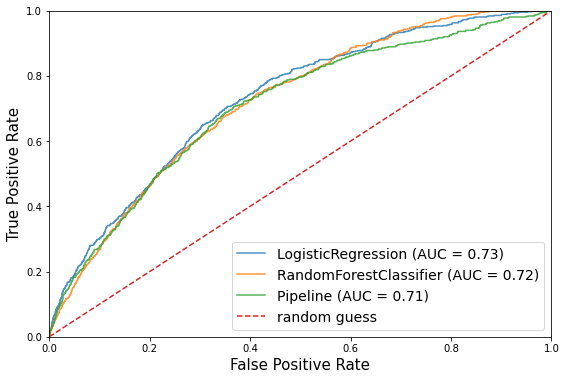

In [66]:
plt.figure(figsize=(9,6))
ax = plt.gca()
lr_disp = plot_roc_curve(hy_logreg, X_test, y_test, ax=ax, alpha=0.8)
rf_disp = plot_roc_curve(hy_rf, X_test, y_test, ax=ax, alpha=0.8)
svc_disp = plot_roc_curve(clf, X_test, y_test, ax=ax, alpha=0.8)
plt.plot([0, 0.5, 1], [0, 0.5, 1], linestyle='--', label='random guess')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.legend(loc="lower right", fontsize=14)
plt.show()

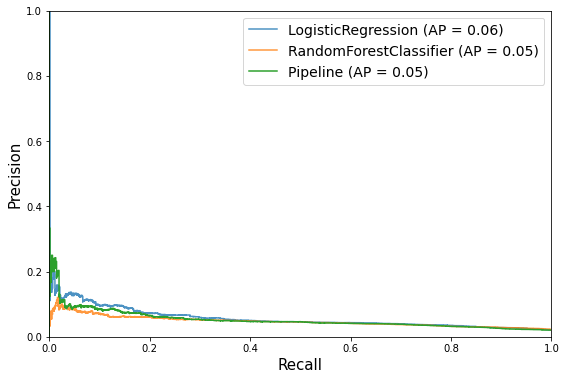

In [67]:
from sklearn.metrics import plot_precision_recall_curve

plt.figure(figsize=(9,6))
ax = plt.gca()
lr_disp = plot_precision_recall_curve(hy_logreg, X_test, y_test, ax=ax, alpha=0.8)
rf_disp = plot_precision_recall_curve(hy_rf, X_test, y_test, ax=ax, alpha=0.8)
svc_disp = plot_precision_recall_curve(clf, X_test, y_test, ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.legend(loc="upper right", fontsize=14)
plt.show()

## Q3: By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email). How would you test that?

In [25]:
sum(y_test)/len(y_test), len(y_test)

(0.020433333333333335, 30000)

### Random guess prediction

In [26]:
frd_rate = sum(y_test)/len(y_test)

In [48]:
from random import random
random_pred = []
for i in range(len(y_test)):
    r = random()
    if r <= frd_rate:
        random_pred.append(1)
    else:
        random_pred.append(0)

In [65]:
print ('accuracy = %.3f' % (len([1 for i in range(len(random_pred)) if random_pred[i]==y_test.values[i]])/len(y_test)))
evaluation(y_test, random_pred)

accuracy = 0.960
P = 0.026 R = 0.026
F1 = 0.026
[[   16   597]
 [  589 28798]]


### Comparison between random guess and ML model prediction 

metric | random | log  | rf   | SVM 
-----  | -----  |----- | ---- | ----
Accuracy|0.960  | 0.86 | 0.850| 0.891
Precision|0.026 | 0.053| 0.05 | 0.056
Recall   |0.026 | 0.356| 0.352| 0.271
F1 score |0.026 | 0.093| 0.088| 0.092

Note few things:
1. Since the data is highly imbalanced, positive rate is only 2%, accuracy is **NOT** a good metric to use.
2. ML gives both higher precision (5%) and higher recalls (35%) than random guess (2.6%). Therefore our ML models catpture more click emails.

## Q4: Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

This session mainly follows the [Regressions and Coefficients](https://productds.com/wp-content/uploads/Logistic_Regression.html) from product data science.

In [46]:
import statsmodels.api as sm

In [47]:
X, y = data.drop(['open', 'click'], axis=1), data["click"]
  
logit = sm.Logit(y, X) # Build Logistic Regression
output = logit.fit() 

Optimization terminated successfully.
         Current function value: 0.094930
         Iterations 9


### Get coefficients and p-values

In [49]:
output_table = pd.DataFrame(dict(coefficients = output.params, SE = output.bse, z = output.tvalues, p_values = output.pvalues))
print(output_table)

                            coefficients            SE          z  \
email_id                   -4.036709e-08  7.684738e-08  -0.525289   
hour                        1.679231e-02  4.944169e-03   3.396387   
user_past_purchases         1.838221e-01  5.671748e-03  32.410134   
email_text_short_email      2.673028e-01  4.472065e-02   5.977168   
email_version_personalized  6.102700e-01  4.616942e-02  13.218056   
weekday_Monday              4.939617e-01  9.135643e-02   5.406972   
weekday_Saturday            2.399955e-01  9.566645e-02   2.508669   
weekday_Sunday              1.770344e-01  9.723449e-02   1.820695   
weekday_Thursday            5.709773e-01  9.038565e-02   6.317124   
weekday_Tuesday             5.713313e-01  9.028047e-02   6.328405   
weekday_Wednesday           7.077664e-01  8.876873e-02   7.973150   
user_country_FR            -3.689332e-02  1.579702e-01  -0.233546   
user_country_UK             1.139571e+00  1.199467e-01   9.500642   
user_country_US             1.1236

### Significant variables

Significant features whose p-value < 0.05

In [51]:
print(output_table[output_table.p_values < 0.05])

                            coefficients        SE          z       p_values
hour                            0.016792  0.004944   3.396387   6.828168e-04
user_past_purchases             0.183822  0.005672  32.410134  1.975787e-230
email_text_short_email          0.267303  0.044721   5.977168   2.270500e-09
email_version_personalized      0.610270  0.046169  13.218056   6.902455e-40
weekday_Monday                  0.493962  0.091356   5.406972   6.409898e-08
weekday_Saturday                0.239995  0.095666   2.508669   1.211869e-02
weekday_Thursday                0.570977  0.090386   6.317124   2.664760e-10
weekday_Tuesday                 0.571331  0.090280   6.328405   2.477091e-10
weekday_Wednesday               0.707766  0.088769   7.973150   1.546800e-15
user_country_UK                 1.139571  0.119947   9.500642   2.085993e-21
user_country_US                 1.123651  0.113889   9.866221   5.832074e-23
intercept                      -6.754374  0.152835 -44.193838   0.000000e+00

### General Insights

The following contents are from [**Regressions and Coefficients** in Product Data Science](https://productds.com/wp-content/uploads/Logistic_Regression.html).
 
* User country seems very important. Especially interesting is that English speaking countries (US, UK) are doing significantly better than non-English speaking countries (ES, FR). That could mean a bad translation or in general a non-localized version of the email. The first thing you want to do here is probably getting in touch with the international team and asking them to review French and Spanish email templates


 
* Not surprisingly, all weekday coefficients are positive. Sunday is (barely) non-significant, all others are significant. This is a consequence of having Friday as reference level. It is a well-known fact that sending marketing emails on Friday is not a great idea. Wednesday seems to be the best day, but in general all week days (Monday-Thursday) perform similarly. Friday - Sunday are much worse. The company should probably start sending emails only Monday-Thursday, with a particular focus on the middle of the week
 
 
* Personalized emails are doing better. So the company should stop sending generic emails. But most importantly, this can be a huge insight from a product standpoint. If just adding the name at the top is increasing clicks significantly, imagine what would happen with even more personalization. Definitely worth investing in this


* Sending short emails appears to be better, but personalizing emails should be the priority vs finding a general optimal email template that on an average works best for everyone (see much lower coefficient compared to the personalization one)


* Hour perfectly emphasizes the problems of logistic regressions with numerical variables. The best time is likely during the day and early mornings and late nights are probably bad. But the model is trying to find a linear relationship between hour and the output. In most cases, this means that will not find a significant relationship. If it does find significance, the results would be highly misleading. Like in this case, it is telling us that the larger the value of hour, the better it is. So the best time would be 24 (midnight)! To solve this, you should manually create segments (i.e. indicator variables) before building the model. One segment could be night time, one morning to noon, etc.


* Email_id is not significant, but the p-value is not that high either, so it is something to keep in mind. Email_id could be interesting because it can be seen as a proxy for time, i.e. the first email sent gets id 1, second id 2, etc. So a significant and negative coefficient would mean that as time goes by, less and less people are clicking on the email. This could be a big red flag, like for instance Google started labeling us as spam. It doesn’t look like the case here, but still, it is something to keep in mind


* More importantly, note the super low coefficient for email_id compared to the other ones. That doesn’t mean that the variable is irrelevant. The super low coefficient simply depends on the fact that email_id scale is way larger than the other variables. The max value of all other variables is 24 for hour. The max value of email_id is 100K! So the low coefficient is meant to balance the different scale, otherwise email_id would entirely drive the regression output.


* The intercept highly negative and significant is the regression outcome if all variables are set to zero. So, basically, categorical variables are all set to their reference levels and numerical variables are set to 0. Intercepts are almost always negative and significant given that in the majority of cases you are dealing with imbalanced classes, where 1s are <5% of the events. And in a logistic regression a negative outcome means higher probability of predicting class zero. Don’t read too much into it. After all, the all-values-are-0 scenario is unrealistic at best, and often impossible. Like here “hour” is coded as from 1 to 24, so it cannot even have the value 0! Only thing, looking at the scale of the intercept vs the scale of the other coefficients * the possible values of those variables can be useful to get a sense of by how much you can affect the output

   * If I send emails on Wednesday, that variable value becomes 0.7 (i.e. 0.7 coefficient times the value of the variable that would be 1) which is pretty high relative to the -6.8 intercept. So opportunities of meaningful improvements are there. Imagine my intercept were -1000 and Wednesday coefficient were the same. Then optimizing the day would be almost irrelevant from a practical standpoint.


## Pros and Cons of using logistic regression coefficients to extract insights from data


### Pros

* Pretty much anyone in a technical or product management role in a tech company is familiar with logistic regressions (if this is not true at your company, you are probably working in the wrong place). It is so much easier to present data science work if the audience is already familiar with the techniques used

* Logistic regressions are by far the most used model in production. Despite all the blog posts, conference talks, etc. about deep learning, it is almost guaranteed that a consumer tech company most important model in production will be a logistic regression. Therefore, it will be easy to collaborate with engineers (i.e. leveraging prior work done by them, helping them improve their model, etc.)

* It is simple, fast, and generally reliable. Indeed, building the model is straightforward. The model works well in the majority of cases and all you have to do is look at the coefficient values and their p-values




### Cons



* Coefficients give an idea of the impact of each variable on the output. But it is actually pretty hard to exactly visualize what that means. I.e., a change in a given variable by one unit changes the log odds ratio by $\beta$ units, where $\beta$ is the coefficient. Mmh…

* Coefficients do not allow to segment a variable. For instance, a positive coefficient in front of variable age means that as age increases, the output keeps increasing as well. Always. This is unlikely to be true for most numerical variables. You often need to create segments before building the regression (btw RuleFit solves exactly this problem)

* Coefficient meaning in front of a categorical variable with several levels can be confusing. You change a given variable reference level and all other level coefficients change

* The absolute value of a coefficient is often used to quickly estimate variable importance. However, that depends on the variable scale more than anything else. You could normalize variables, so they are all on the same scale. But that’s rarely a good idea if your goal is presenting to product people. It is hard to get a product manager excited by saying: “If we increase variable X by one standard deviation, we could achieve this and that”
 